# **NLP - CA4 - Question 2**

**Parnian Fazel (810198516)**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
from transformers import BertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Question2_Data/train.xlsx" .
!cp "/content/drive/MyDrive/Question2_Data/test.xlsx" .
!cp "/content/drive/MyDrive/Question2_Data/valid.xlsx" .

In [ ]:
train_df = pd.read_excel('/content/train.xlsx')
test_df = pd.read_excel('/content/test.xlsx')
train_df

,source,targets,category
0,"When news is brought to one of them, of (the b...",و چون یکی از آنان را به [ولادت] دختر مژده دهند...,quran
1,After them repaired Zadok the son of Immer ove...,و چون دشمنان ما شنیدند که ما آگاه شده‌ایم و خد...,bible
2,And establish regular prayers at the two ends ...,و نماز را در دو طرف روز و ساعات نخستین شب برپا...,quran
3,"And it came to pass, that, when I was come aga...",و فرمود تا مدعیانش نزد تو حاضر شوند؛ و از او ب...,bible
4,"Ah woe, that Day, to the Rejecters of Truth!",وای در آن روز بر تکذیب کنندگان!,quran
...,...,...,...
12595,"Women impure are for men impure, and men impur...",زنان پلید برای مردان پلید و مردان پلید برای زن...,quran
12596,I don't want any silly dance given in my honour.',بنابراین حالا هم میل ندارم جشنی به افتخار من د...,mizan
12597,And the Earth will shine with the Glory of its...,و زمین به نور پروردگارش روشن می‌شود، و کتاب [ا...,quran
12598,"Then lifted I up mine eyes, and saw, and behol...",گفتم: «این چیست؟» او جواب داد: «این است آن ایف...,bible


quran    4200
bible    4200
mizan    4200
Name: category, dtype: int64


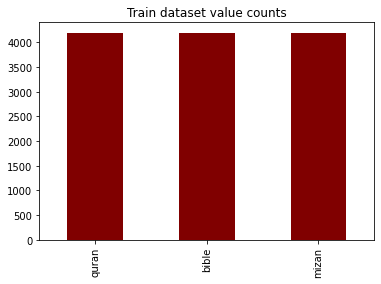

In [ ]:
print(train_df['category'].value_counts())
plt.title("Train dataset value counts")
train_df['category'].value_counts().plot.bar(color='maroon')

mizan    900
bible    900
quran    900
Name: category, dtype: int64


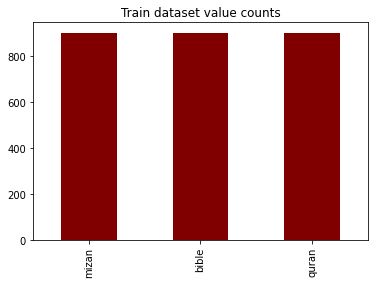

In [ ]:
print(test_df['category'].value_counts())
plt.title("Train dataset value counts")
test_df['category'].value_counts().plot.bar(color='maroon')

In [ ]:
class Classifier:
    def __init__(self, model_address, train_column_name, test_column_name, batch_size=32, seq_len=128):
      self.train_df = pd.read_excel('/content/train.xlsx')
      self.valid_df = pd.read_excel('/content/valid.xlsx')
      self.test_df = pd.read_excel('/content/test.xlsx')
      self.encoded_dict = {'quran' : 0, 'bible': 1, 'mizan': 2}
      self.seq_len = seq_len
      self.model_address = model_address
      self.train_column_name = train_column_name
      self.test_column_name = test_column_name
      self.batch_size = batch_size
      self.prepare_data()
      self.set_model_and_tokenizer()

    def encode_classes(self, df):
      return df.category.map(self.encoded_dict)

    def prepare_data(self):
      self.train_df['category'] = self.encode_classes(self.train_df)
      self.valid_df['category'] = self.encode_classes(self.valid_df)
      self.test_df['category'] = self.encode_classes(self.test_df)  

    def set_model_and_tokenizer(self):
      if self.model_address != 'xlm-roberta-base':
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
        self.bert = TFAutoModel.from_pretrained(self.model_address)
      else: 
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_address, from_pt=True)
        self.bert = TFAutoModel.from_pretrained(self.model_address, from_pt=True)

    def get_tokenized_ids(self, df, column_name):
      record_len = len(df)
      xinput_ids = np.zeros((record_len, self.seq_len))
      xmask_ids = np.zeros((record_len, self.seq_len))

      for i, row in df.iterrows():
        if self.model_address != 'xlm-roberta-base':
          input_data = row[column_name]
        else:
          input_data = row['source'], row['targets']

        tokens = self.tokenizer.encode_plus(input_data, max_length=self.seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True,
                                      return_tensors='tf')
        xinput_ids[i, :] = tokens['input_ids']
        xmask_ids[i, :] = tokens['attention_mask']

      class_values = df['category'].values
      labels = np.zeros((record_len, class_values.max()+1))
      labels[np.arange(record_len), class_values] = 1 #one-hot encoding
      return xinput_ids, xmask_ids, labels


    def dataset_mapper(self, input_ids, masks, labels):
      return {'input_ids': input_ids, 'attention_mask': masks}, labels


    def get_dataset(self, df, column_name):
      xinput_ids, xmask_ids, labels = self.get_tokenized_ids(df, column_name)
      dataset = tf.data.Dataset.from_tensor_slices((xinput_ids, xmask_ids, labels))
      dataset = dataset.map(self.dataset_mapper)
      return dataset.batch(self.batch_size, drop_remainder=True)

    def create_model(self):
      input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
      mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

      embeddings = self.bert(input_ids, attention_mask=mask).pooler_output
      drop_output = tf.keras.layers.Dropout(0.7)(embeddings)
      output = tf.keras.layers.Dense(1024, activation='relu')(drop_output)
      y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(output)

      model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
      #model.layers[2].trainable = False #for freezing bert layer
      optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
      loss = tf.keras.losses.CategoricalCrossentropy()
      acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
      model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
      print(model.summary())
      return model

    def train_and_evaluate_model(self, model):
      train_dataset = self.get_dataset(self.train_df, self.train_column_name)
      valid_dataset = self.get_dataset(self.valid_df, self.train_column_name)
      xinput_ids_test, Xmask_test, labels_test = self.get_tokenized_ids(self.test_df, self.test_column_name)
      history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)
      score = model.evaluate([xinput_ids_test, Xmask_test], labels_test, verbose=0)
      print("Loss on test data:", score[0])
      print("Accuracy on test data:", score[1])
      print("Classification Report:")
      predictions = np.argmax(model.predict([xinput_ids_test, Xmask_test]), axis=1)
      print(classification_report(self.test_df['category'], predictions, target_names=['quran', 'bible', 'mizan']))
      
      for i, classification in enumerate(["quran", "bible", "mizan"]):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(self.test_df['category'].to_list()), np.array(predictions), pos_label=i)
        auc_res = metrics.auc(fpr, tpr)
        print(f"AUC - {classification}: ", auc_res)

      self.plot_results(history)
      self.print_confusion_matrix(self.test_df['category'].to_list(), predictions)
      return model, history, score, predictions

    def plot_results(self, history):
      plt.style.use('seaborn')
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_figheight(4)
      fig.set_figwidth(12)
      
      ax1.plot(history.history["accuracy"], label = "Train")
      ax1.plot(history.history["val_accuracy"], label ="Validation")
      ax1.set_ylabel("Accuracy")
      ax1.set_xlabel("Epoch")
      ax1.legend()

      ax2.plot(history.history["loss"], label = "Train")
      ax2.plot(history.history["val_loss"], Label = "Validation")
      ax2.set_ylabel("Loss")
      ax2.set_xlabel("Epoch")
      ax2.legend()

      fig.suptitle(f"Results for {self.model_address} Model", fontsize="x-large", y=1.05)
      plt.tight_layout()
      plt.show()

    def print_confusion_matrix(self, y_test, y_pred):
      conf_mat = confusion_matrix(y_test, y_pred)
      ax = plt.subplot()
      sns.heatmap(conf_mat, annot = True, ax = ax, linewidths = 5, linecolor = 'y', center = 0)
      ax.set_title(f"Confusion Matrix for {self.model_address} Model")
      ax.set_xlabel('Predicted Labels') 
      ax.set_ylabel('True Labels')
      ax.xaxis.set_ticklabels(["quran", 'bible', 'mizan'])
      ax.yaxis.set_ticklabels(["quran", 'bible', 'mizan'])
      plt.show()

## **Part 1**

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

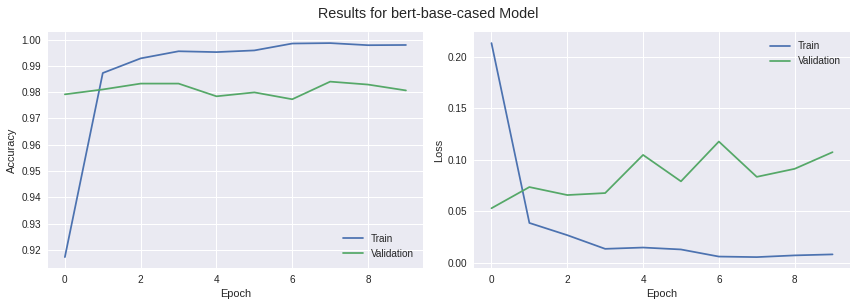

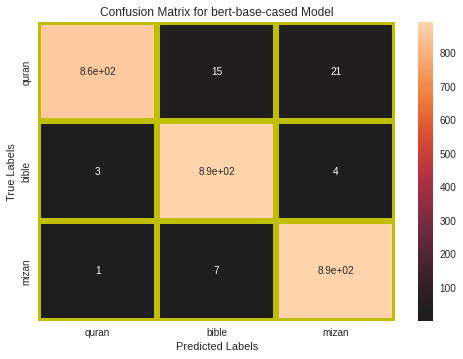

In [ ]:
classifier_Bert = Classifier('bert-base-cased', 'source', 'source',  batch_size=32, seq_len=128)
part1_model = classifier_Bert.create_model()
part1_model, part1_history, part1_score, part1_predictions = classifier_Bert.train_and_evaluate_model(part1_model)

## **Part 2**

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/919M [00:00<?, ?B/s]

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  162841344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

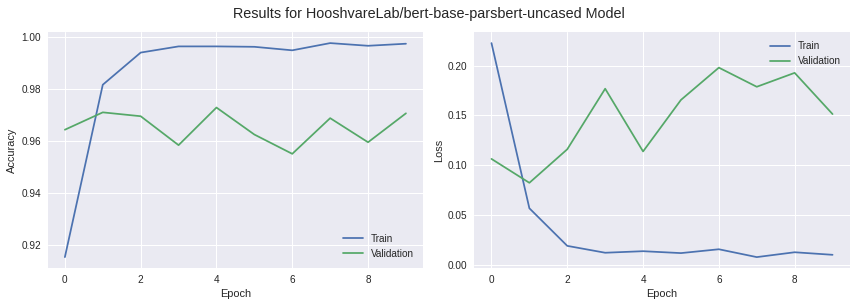

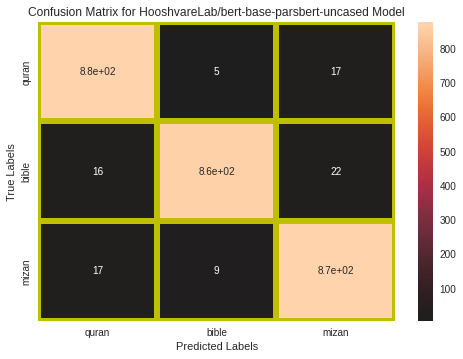

In [ ]:
classifier_ParsBert = Classifier('HooshvareLab/bert-base-parsbert-uncased', 'targets', 'targets', batch_size=32, seq_len=128)
part2_model = classifier_ParsBert.create_model()
part2_model, part2_history, part2_score, part2_predictions = classifier_ParsBert.train_and_evaluate_model(part2_model)

# **Part 3**

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tfxlm_roberta_model_2 (TFXLMRo  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 bertaModel)                    thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

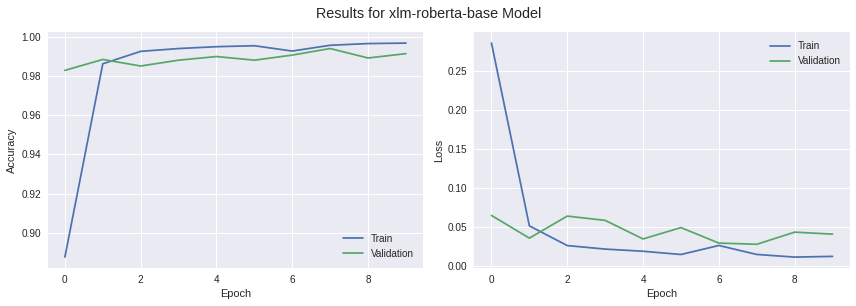

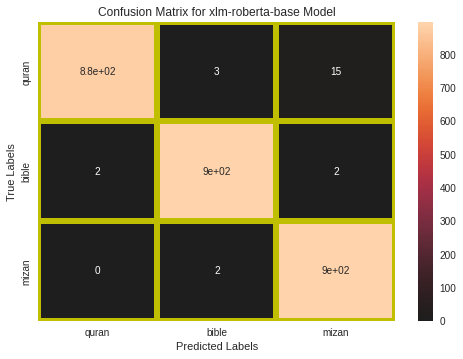

In [ ]:
classifier_XLMR = classifier('xlm-roberta-base', '', '', batch_size=32, seq_len=128)
part3_model = classifier_XLMR.create_model()
part3_model, part3_history, part3_score, part3_predictions = classifier_XLMR.train_and_evaluate_model(part3_model)